Notebook to compare stratification between two simulations.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import glob
from salishsea_tools import tidetools, nc_tools
import matplotlib.dates as md

import sys
sys.path.append('/data/nsoontie/MEOPAR/mixing-paper/analysis')

import mixing
import ONC_patrols as onc

%matplotlib inline

# Load Mesh

In [2]:
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
bathy, lons, lats = tidetools.get_bathy_data(grid_B)

tmask = mesh_mask.variables['tmask'][:]
tmask = 1-tmask

gdept = mesh_mask.variables['gdept'][0,:,:,:]
gdepw = mesh_mask.variables['gdepw'][0,:,:,:]

thalweg_points, gdept_thal, xx = mixing.load_thalweg(gdept, lons, lats)


# Load files

In [3]:
start=datetime.datetime(2015,7,9)
end=datetime.datetime(2015,8,17)
home_dir = '/ocean/nsoontie/MEOPAR/SalishSea/results/mixing_paper/'

In [4]:
runs = ['base_jul', 'biharm_600']
grid_t={}
grid_w={}
for run in runs:
    grid_t[run] = mixing.results_dataset('1d',start,end,'grid_T',home_dir,run)
    grid_w[run] = mixing.results_dataset('1d',start,end,'grid_W',home_dir,run)

In [5]:
sals={}; temps={}; avts={}; times={}; depthts={}; depthws={}

for run in runs:
    sals[run] = mixing.load_field(grid_t[run],tmask,'vosaline')
    temps[run] = mixing.load_field(grid_t[run],tmask,'votemper')
    times[run] = mixing.load_time(grid_t[run])

In [6]:
def plot_thalweg_diff(ax, t, var, var_name, dates, thalweg_points, depth,  xx, runs, smin=-1,smax=1, 
                     lines=[-.5, -.25,0,.25,.5], cmap='bwr',xlim=[0,750]):
    
    diff = var[runs[1]] - var[runs[0]]
    diffP=diff[t,:,thalweg_points[:,0],thalweg_points[:,1]]
    mesh=ax.pcolormesh(xx,depth,diffP.T,vmin=smin,vmax=smax,cmap=cmap)
    
    CS = ax.contour(xx,depth,diffP.T,lines,colors='k')
    plt.clabel(CS)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    cbar.add_lines(CS)
    
    ax.set_ylim([430,0])
    ax.set_xlim(xlim)
    ax.set_ylabel('Depth [m]')
    ax.set_title('{} - {} on {} '.format(runs[1],runs[0],dates[t].strftime('%d-%b-%Y %H:%M')))

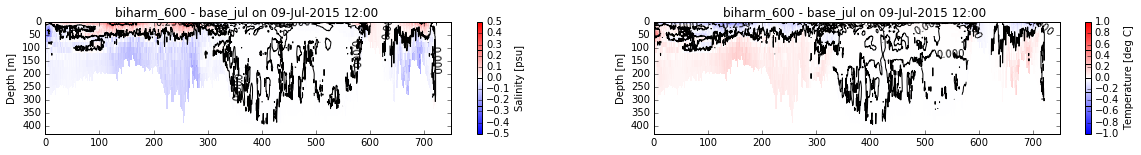

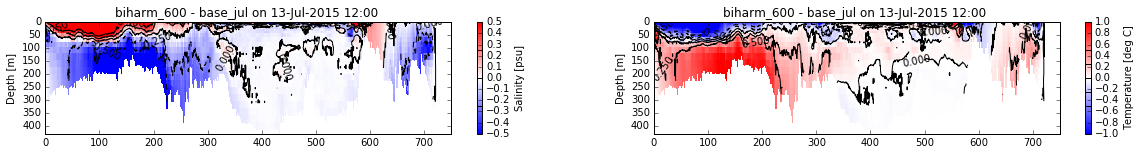

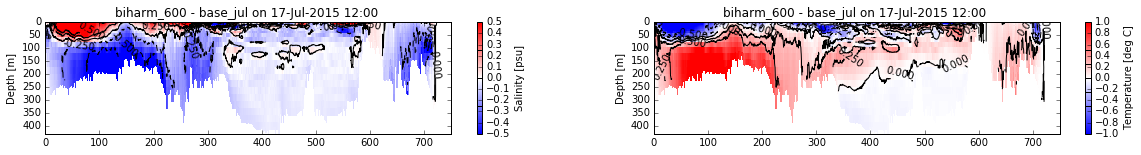

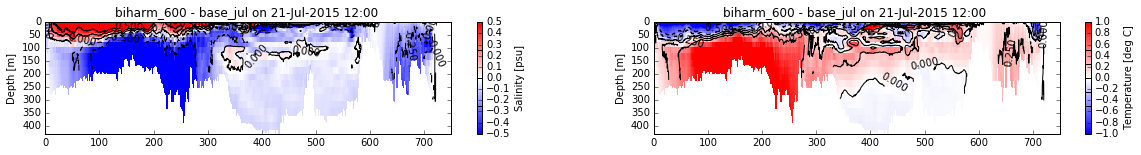

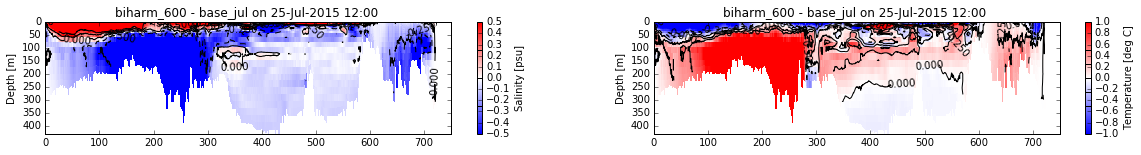

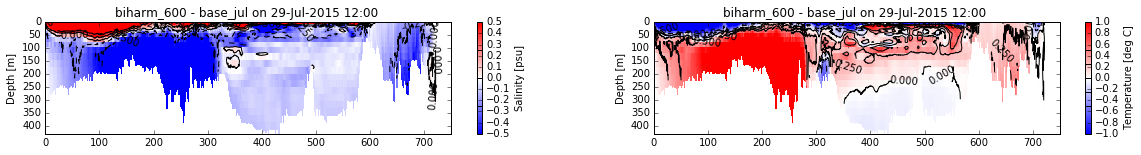

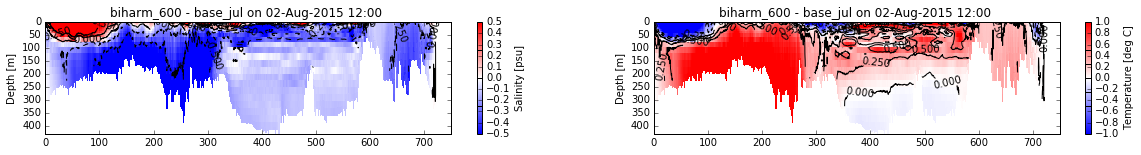

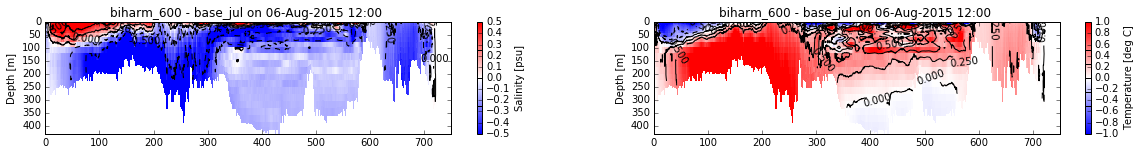

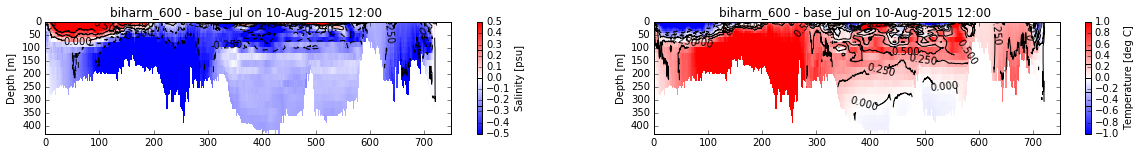

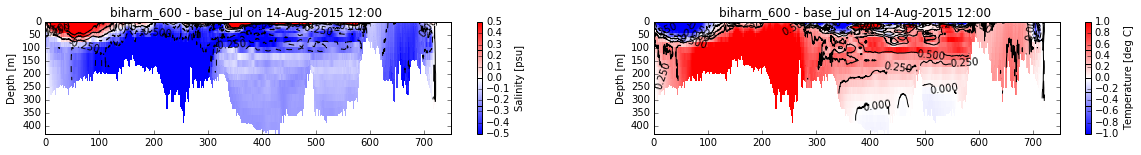

In [7]:
for t in np.arange(0,sals[runs[0]].shape[0],4):
    fig,axs = plt.subplots(1,2,figsize=(20,2))
    ax=axs[0]
    plot_thalweg_diff(ax, t, sals, 'Salinity [psu]', times[runs[0]], thalweg_points, gdept_thal, xx, runs,
                     smin=-.5, smax=.5)
    ax=axs[1]
    plot_thalweg_diff(ax, t, temps, 'Temperature [deg C]', times[runs[0]], thalweg_points, gdept_thal,xx,runs,
                     smin=-1, smax=1)

# Surface

In [8]:
def plot_surface(ax, t,d, var, var_name, run, dates, smin=0,smax=34,cmap='Spectral_r'):
    
    mesh=ax.pcolormesh(var[t,d,:,:],vmin=smin,vmax=smax,cmap=cmap)
    
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    
    ax.set_title('{} on {} '.format(run,dates[t].strftime('%d-%b-%Y %H:%M')))

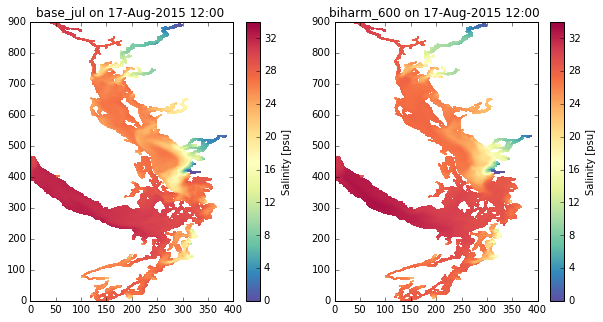

In [9]:
d=0
t=39
fig,axs = plt.subplots(1,2,figsize=(10,5))
for run, ax in zip(runs,axs):
    sal = sals[run]
    plot_surface(ax, t, d,sal, 'Salinity [psu]', run, times[run])


# Regions and casts

In [10]:
bad_QC=[0,3,4,9]

In [11]:
data_dir = '/ocean/nsoontie/MEOPAR/ONC/Patrols/'
region = 'Victoria'
data_sub = mixing.load_obs_region(region, start, end)

/data/nsoontie/MEOPAR/mixing-paper/analysis/ONC_patrols.py:130: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  data = data.convert_objects(convert_numeric=True)


In [12]:
sal_regs={}
lats_regs={}
lons_regs={}
time_regs ={}
temp_regs={}
gdep_regs={}
for run in runs:
    fields, time_regs[run], gdep_regs[run], lons_regs[run], lats_regs[run] = mixing.load_model_region(region, run, home_dir, lons, lats,tmask, gdept,
                                                            ['vosaline', 'votemper'])
    sal_regs[run] = fields['vosaline']
    temp_regs[run] = fields['votemper']

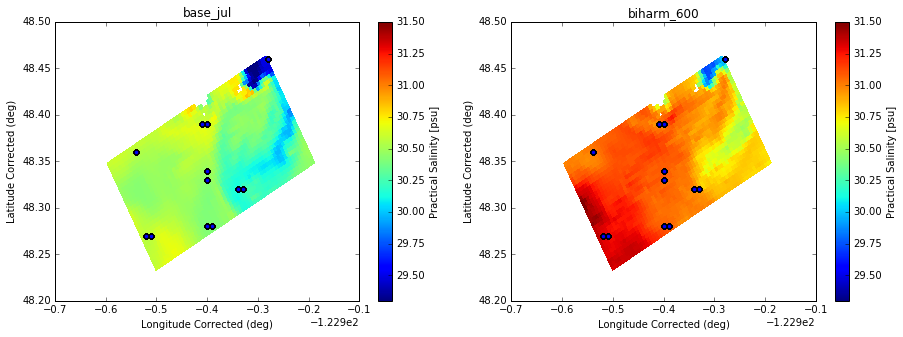

In [21]:
t=28
d=0
fig,axs = plt.subplots(1,2,figsize=(15,5))
for run, ax in zip(runs, axs):
    mesh=ax.pcolormesh(lons_regs[run], lats_regs[run],sal_regs[run][t,0,:,:],vmin=29.3,vmax=31.5)
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('Practical Salinity [psu]')
    ax.set_title(run)
    data_sub.plot(x='Longitude Corrected (deg)', y='Latitude Corrected (deg)',ax=ax,kind='scatter')

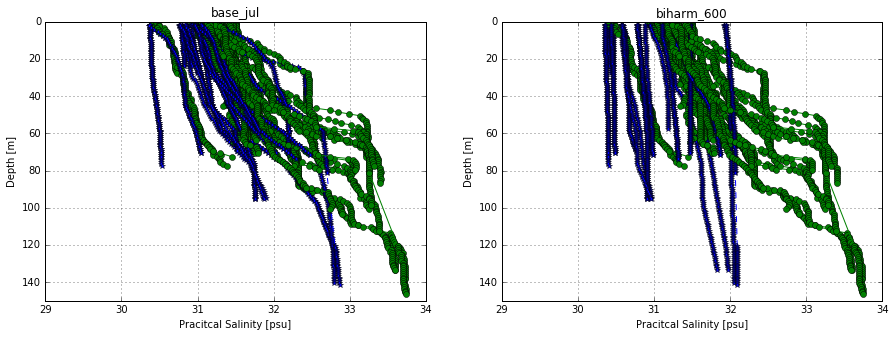

In [14]:
datacast = data_sub.groupby('Cast')
fig,axs=plt.subplots(1,2,figsize=(15,5))
for run, ax in zip(runs, axs):
    for c in datacast.groups:
        cast = datacast.get_group(c).dropna()
        lat, lon, date = onc.cast_position_and_time(cast)
        obs_depth = np.array(cast['Depth Corrected (m)'])
        try:
            model = mixing.retrieve_model_cast(lon,lat,date, obs_depth, sal_regs[run],
                                               lons_regs[run],lats_regs[run],
                                               time_regs[run], gdep_regs[run], sal_regs[run].mask[0,0,:,:])
            ax.plot(cast['Practical Salinity Corrected (psu)'],
                    obs_depth, '-go')
            ax.plot(model.mean(axis=0), obs_depth, '--b*')
        except ValueError:
            print('No model point {}, {} found'.format(lon, lat))
    ax.set_title(run)
    ax.set_ylim([150,0])
    ax.set_xlim([29,34])
    ax.set_xlabel('Pracitcal Salinity [psu]')
    ax.set_ylabel('Depth [m]')
    ax.grid()

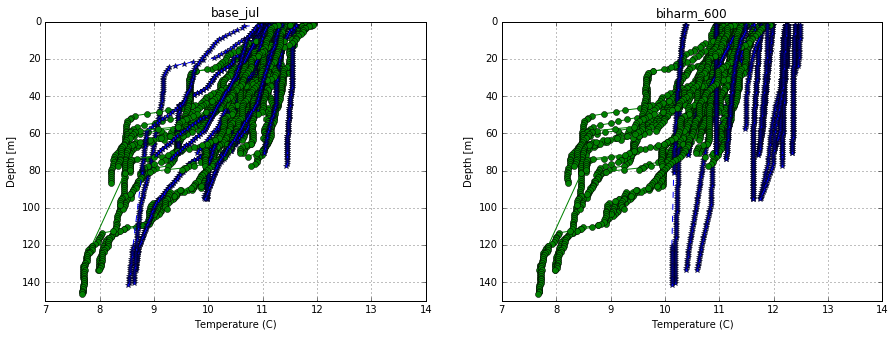

In [15]:
datacast = data_sub.groupby('Cast')
fig,axs=plt.subplots(1,2,figsize=(15,5))
for run, ax in zip(runs, axs):
    for c in datacast.groups:
        cast = datacast.get_group(c).dropna()
        lat, lon, date = onc.cast_position_and_time(cast)
        obs_depth = np.array(cast['Depth Corrected (m)'])
        try:
            model = mixing.retrieve_model_cast(lon,lat,date, obs_depth, temp_regs[run],
                                               lons_regs[run],lats_regs[run],
                                                time_regs[run], gdep_regs[run], temp_regs[run].mask[0,0,:,:])
            ax.plot(cast['Temperature Corrected (C)'],
                     obs_depth,'-go')
            ax.plot(model.mean(axis=0), obs_depth, '--b*')
        except ValueError:
            print('No model point {}, {} found'.format(lon, lat))
    ax.set_title(run)
    ax.set_ylim([150,0])
    ax.set_xlim([7,14])
    ax.set_xlabel('Temperature (C)')
    ax.set_ylabel('Depth [m]')
    ax.grid()